# Control robotic vehicle using intelligent techiques of Machine Learning

# Έλεγχος Ρομποτικού οχήματος με ευφυείς τεχνικές Μηχανικής Μάθησης`

In [ ]:
! pip install beautifultable

In [ ]:
import os
import random
import pathlib

from matplotlib import cm
import matplotlib.colors as mcolors

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from skimage.measure import block_reduce
from beautifultable import BeautifulTable

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import librosa
import librosa.display

from google.colab import files 

## Dataset preview

Dataset: [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands). The original dataset consists of over 105,000 WAV audio files of people saying thirty different words. This data was collected by Google and released under a CC BY license. These words are either:
<br/><br/> Words:
*   Basic Words: **Yes**, **No**, **Up**, **Down**, **Left**, **Right**, On, Off, **Stop**, **Go**, Zero, **One**, **Two**, **Three**, Four, Five, Six, Seven, Eight, and Nine.
*   Auxiliary Words: Bed, Bird, Cat, Dog, Happy, House, Marvin, Sheila, Tree, and Wow.
*  Environment's noise: doing_the_dishes, dude_miaowing, exercise_bike, pink_noise, running_tap, and white_noise.

Location: `speech_commands_v0` folder in GoogleDrive

<br/> In bold have been marked the words that will be used for training. For proper memory managment the other words have been removed. As a result in `speech_commands_v0.01` are located samples of 11 selected words.


Check [Read Commands](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [ ]:
# Connection with google colab in order to load dataset
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


In [ ]:
# Change Direcotry and set dataset_dir as default
os.chdir('/content/drive/MyDrive/my_project/speech_commands_v0.01')

In [ ]:
!pwd

/content/drive/MyDrive/Thesis_George_Giannios/speech_commands_v0.01


In [ ]:
data_dir = os.getcwd()
print(data_dir)

/content/drive/MyDrive/Thesis_George_Giannios/speech_commands_v0.01


In [ ]:
## Check basic statistics about the dataset.
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print("Commands:", commands)

Commands: ['left' 'right' 'go' 'stop' 'yes' 'no' 'up' 'down' 'one' 'two' 'three'
 'four']


In [ ]:
## Extract the audio files into a list and shuffle it.
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of total examples:', num_samples)

Number of total examples: 28462


In [ ]:
## Preview dataset 
table = BeautifulTable()
table.column_headers = ["", "Samples"]
for command in commands:
  table.append_row([command,  len(tf.io.gfile.listdir(data_dir+'/'+str(command)))])

table.append_row(['TOTAL',num_samples])
print(table)

/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


+-------+---------+
|       | Samples |
+-------+---------+
| left  |  2354   |
+-------+---------+
| right |  2373   |
+-------+---------+
|  go   |  2372   |
+-------+---------+
| stop  |  2381   |
+-------+---------+
|  yes  |  2377   |
+-------+---------+
|  no   |  2375   |
+-------+---------+
|  up   |  2379   |
+-------+---------+
| down  |  2359   |
+-------+---------+
|  one  |  2371   |
+-------+---------+
|  two  |  2383   |
+-------+---------+
| three |  2366   |
+-------+---------+
| four  |  2372   |
+-------+---------+
| TOTAL |  28462  |
+-------+---------+


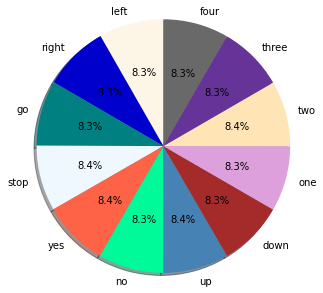

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = commands
sizes = [len(tf.io.gfile.listdir(data_dir+'/'+str(command))) for command in commands]
colors = random.choices(list(mcolors.CSS4_COLORS.values()),k = 12)

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True,colors = colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

As we see, dataset is balacned. The samples of each label are almost equal.

### Split Dataset

In [ ]:
def split_dataset(dataset, train_size):
  
  #Reminder: Dataset has already been shuffled
  num_samples = len(dataset)
  train_samples= round(train_size * num_samples)

  train_fs = dataset[:train_samples]
  test_fs = dataset[train_samples:]

  return train_fs,test_fs

In [ ]:
# We define (%) of test and val dataset 
test_size = 0.1
val_size = 0.1

# Train - Test split 
train_files, test_files = split_dataset(filenames, 1-test_size)
# Train - Val split 
train_files, val_files = split_dataset(train_files, 1 - val_size/(1-test_size))


In [ ]:
table = BeautifulTable()
table.column_headers = ["", "Samples", "Size(%)"]

table.append_row(['train',len(train_files),(1 - val_size - test_size)*100])
table.append_row(['val',len(val_files),val_size*100])
table.append_row(['test',len(test_files),test_size*100])

print(table)
print("Total Samples:",num_samples)

+-------+---------+---------+
|       | Samples | Size(%) |
+-------+---------+---------+
| train |  22770  |  80.0   |
+-------+---------+---------+
|  val  |  2846   |  10.0   |
+-------+---------+---------+
| test  |  2846   |  10.0   |
+-------+---------+---------+
Total Samples: 28462


/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


## Read audio files - Future Extraction

In this step we read audio files using `tf.audio.decode_wav` that converts them into numerical tensors.  Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system the values range from -32768 to 32767. The sample rate for this dataset is 16kHz. Note that this function will normalize the values to the range [-1.0, 1.0].

In [ ]:
# Example:
audio_binary = tf.io.read_file("three/8c3c4715_nohash_2.wav")

# The -32768 to 32767 signed 16-bit values 
# link: https://stackoverflow.com/questions/5890499/pcm-audio-amplitude-values
# see matrix in Wiki: https://en.wikipedia.org/wiki/Audio_bit_depth
audio, f = tf.audio.decode_wav(audio_binary)
a = tf.squeeze(audio, axis=-1)
print(a.numpy())

[ 0.00057983  0.00076294  0.00100708 ... -0.00085449 -0.00067139
 -0.00054932]


In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)

  '''
  audio = tf.Tensor(
  [[ 0.00057983]
  [ 0.00076294]
  [ 0.00100708]
  ...
  [-0.00085449]
  [-0.00067139]
  [-0.00054932]], shape=(16000, 1), dtype=float32)
  '''
  return tf.squeeze(audio, axis=-1)

  '''
  tf.Tensor(
  [ 0.00057983  0.00076294  0.00100708 ... -0.00085449 -0.00067139
    -0.00054932], shape=(16000,), dtype=float32)

  '''

The label for each WAV file is its parent directory.

In [ ]:
def get_label(file_path):
  #  Reminder:
  ## filepath: "MyDrive/Thesis_George_Giannios/speech_commands_v0.01/three/8c3c4715_nohash_2.wav"
  parts = tf.strings.split(file_path, os.path.sep)
  
  #So parts[-2] returns in this example: "three"
  return parts[-2]

Define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Why we use 
```Dataset.from_tensor_slices()``` :

The tf.data.Dataset API supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:

*   Create a source dataset from your input data.
*   Apply dataset transformations to preprocess the data.
*   Iterate over the dataset and process the elements.

Iteration happens in a **streaming fashion**, so the full dataset does not need to fit into memory

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE                                                     # The number of parallel calls is set dynamically based on available CPU

files_ds = tf.data.Dataset.from_tensor_slices(train_files)                      # Convert each sample to "tf.Tensor(b'/content/drive/MyDrive/Thesis_George_Giannios/speech_commands_v0.01/three/8c3c4715_nohash_2.wav', shape=(), dtype=string)"
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE) # Applying transformation to  to seperate labels and wav files

In [ ]:
# Now we want to find unique labels and plot audio's amplitude along time
total_commands = len(commands)
print("Total Commands are", total_commands)

Total Commands are 12


### Applying Pre-Emphasis

In [ ]:
pre_emphasis = 0.97

In [ ]:
# The first step is to apply a pre-emphasis filter on the signal to amplify the high frequencies. 
# A pre-emphasis filter is useful in several ways: 
#  (1) balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies, 
#  (2) avoid numerical problems during the Fourier transform operation and (3) may also improve the Signal-to-Noise Ratio (SNR).

def get_pre_emphasided(waveform, pre_emphasis = pre_emphasis):
  
  # Applying: y(t)=x(t)−αx(t−1)
  
  x_0 = 0 
  # x[0] is almost always equal to '0'
  t1 = tf.constant([x_0],dtype='float32')
  t2 = waveform[1:] - pre_emphasis * waveform[:-1]
  
  emphasized_signal = tf.concat([t1, t2], 0)
  return emphasized_signal


In [ ]:
# Example: Emphasided Signal
for waveform, label in waveform_ds.take(5):
  label = label.numpy().decode('utf-8')
  emphasized_signal = get_pre_emphasided(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Emphasized_signal shape:', emphasized_signal.shape)
print('Audio playback')
display.display(display.Audio(emphasized_signal, rate=16000))

Label: four
Waveform shape: (16000,)
Emphasized_signal shape: (16000,)
Audio playback


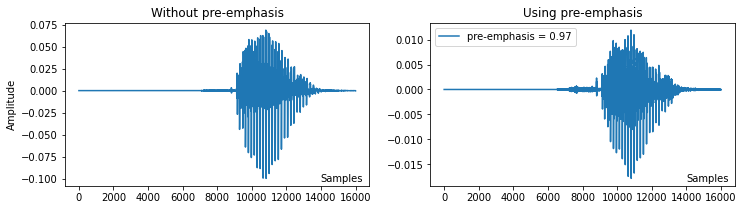

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_pre_emphasided(emphasized_signal, ax):
  ax.plot(emphasized_signal)

fig,(ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12,3)
#fig.suptitle('Time Domain Analysis for command: '+label)

timescale = np.arange(waveform.shape[0])
ax1.plot(timescale, waveform.numpy())
ax1.set_title('Without pre-emphasis')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Amplitude')
ax1.xaxis.set_label_coords(0.91, 0.075)
#axes[0].set_xlim([0, 16000])
plot_pre_emphasided(emphasized_signal.numpy(), ax2)
ax2.set_title('Using pre-emphasis')
ax2.legend(["pre-emphasis = "+ str(pre_emphasis)])
ax2.set_xlabel('Samples')
ax2.xaxis.set_label_coords(0.91, 0.075)
#ax2.set_ylabel('Amplitude')
#axes[1].set_xlim([0, 16000])
#plt.show()

fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('time0.png')
files.download("time0.png")

In [ ]:
# Now transform the waveform dataset to have pre-emphasided waveform dataset and their corresponding labels as integer IDs.
def get_pre_emphasided_and_label_id(audio, label):
  emphasized_signal = get_pre_emphasided(audio)
  label_id = tf.argmax(label == commands)
  return emphasized_signal, label_id

In [ ]:
# Applying transform
wavefrom_ds = waveform_ds.map(get_pre_emphasided_and_label_id, num_parallel_calls=AUTOTUNE)

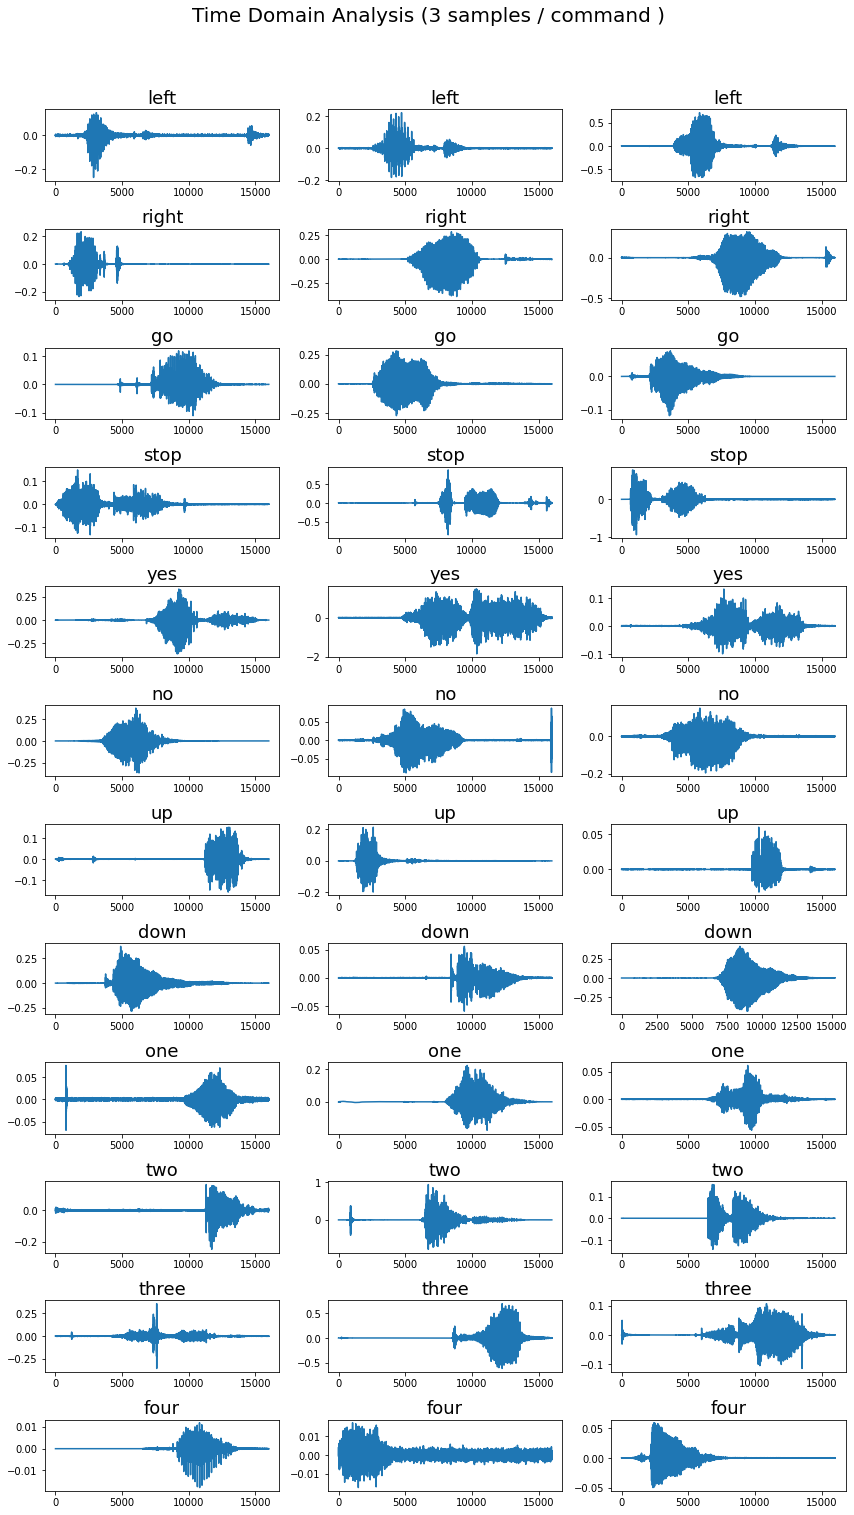

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

<Figure size 216x288 with 0 Axes>

In [ ]:
                                                                                                                                                                                                                                                                                                                                                  # Time Domain Analysis (3 samples / command )
seen_labels = np.zeros(total_commands,dtype = int)

rows = total_commands
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 20))
fig.suptitle('Time Domain Analysis (3 samples / command )',y=1.05,fontsize = 20)


# Search in 100 samples 
for (emphasized_signal, label_id) in wavefrom_ds.take(100):
  id = label_id.numpy()
  if (seen_labels[id] <= 2):
    ax = axes[id][seen_labels[id]]
    seen_labels[id] = seen_labels[id] + 1 
    plot_pre_emphasided(emphasized_signal.numpy(), ax)
    #if (seen_labels[id] == 1):
    #  ax.set_ylabel('Amplittude',fontsize = 14)
    ax.set_title(commands[label_id.numpy()],fontsize=18)
    #ax.axis('off')


plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()
plt.figure(figsize=(3,4))
fig1.savefig('time.png')
files.download("time.png") 

### Frequency Domain 

Source: [
FFT with Python](https://github.com/balzer82/FFT-Python/blob/master/FFT-Tutorial.ipynb). 
<br/>Using hamming window, for avoiding Leakage Effect (remember Fourier Transform was originally invented by Mr Fourier for, and only for, periodic signals). The signal has to be strictly periodic, which introduces the so called windowing to eliminate the leakage effect.



In [ ]:
# Example: Plotting a simple audio signal along time
filename = "three/8c3c4715_nohash_2.wav"
parts = tf.strings.split(filename, os.path.sep)

# Extract samples of audio 
audio_binary = tf.io.read_file(filename)
audio, f = tf.audio.decode_wav(audio_binary)
time_domain = tf.squeeze(audio, axis=-1)

In [ ]:
#Pre-emphasis Example:
pre_emphasis = 0.97 

# Applying pre-emphasis
emphasized_signal = get_pre_emphasided(time_domain,pre_emphasis)

In [ ]:
def get_fft (waveform, two_sided = False):
  # Applying Window 
  hann = np.hanning(len(waveform))
  
  ##FFT algorithm for DFT computation
  Y = np.fft.fft(hann*waveform)
  # Y = 16000
  
  N = int(len(Y)/2+1)
  # N = 8001

  dt = 1
  fa = 16000.0/dt # scan frequency


  if two_sided == True:
    X1 = np.linspace(0, fa, int(fa), endpoint=True)
    Y1 = np.abs(Y)/fa
  else:
    X1 = np.linspace(0, fa/2, N, endpoint=True)
    Y1 = 2.0*np.abs(Y[:N])/N
  return X1,Y1

Text(0, 0.5, 'DFT Amplitude')

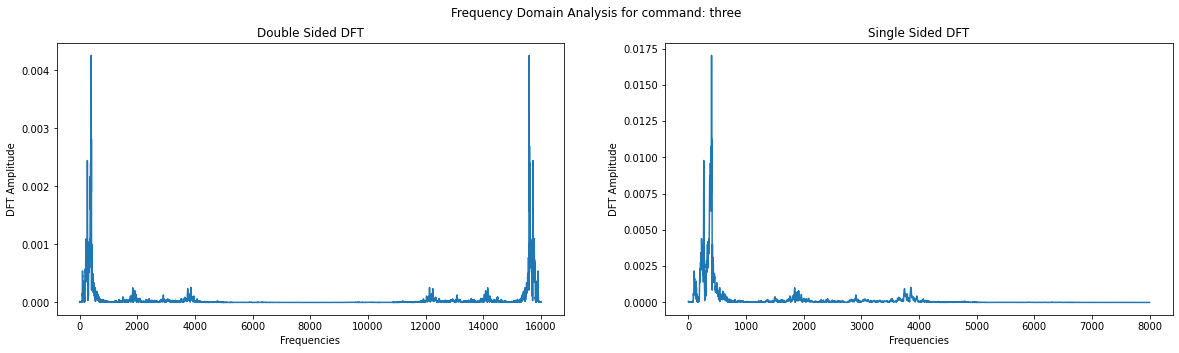

In [ ]:
#Two Sided FFT

X1,Y1 = get_fft(time_domain,two_sided = True)
X2,Y2 = get_fft(time_domain)

# Plot both  pre-emphasided & pre-emphasided signal
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20,5)
fig.suptitle('Frequency Domain Analysis for command: '+str(parts[-2].numpy().decode('utf-8')))

ax1.plot(X1,Y1)
ax1.set_title('Double Sided DFT')
ax1.set_xlabel('Frequencies')
ax1.set_ylabel('DFT Amplitude')

ax2.plot(X2,Y2)
ax2.set_title('Single Sided DFT')
ax2.set_xlabel('Frequencies')
ax2.set_ylabel('DFT Amplitude')

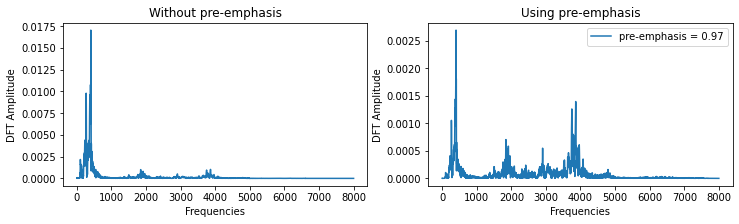

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
X1,Y1 = get_fft(time_domain)
X2,Y2 = get_fft(emphasized_signal.numpy())

# Plot both  pre-emphasided & pre-emphasided signal
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12,3)
#fig.suptitle('Frequency Domain Analysis for command: '+str(parts[-2].numpy().decode('utf-8')))

ax1.plot(X1,Y1)
ax1.set_title('Without pre-emphasis')
ax1.set_xlabel('Frequencies')
#ax1.xaxis.set_label_coords(0.91, 0.1)
ax1.set_ylabel('DFT Amplitude')

ax2.plot(X2,Y2)
ax2.legend(["pre-emphasis = "+ str(pre_emphasis)])
ax2.set_title('Using pre-emphasis')
ax2.set_xlabel('Frequencies')
ax2.set_ylabel('DFT Amplitude')
#ax2.xaxis.set_label_coords(0.91, 0.085)


plt.show()
plt.draw()
fig.tight_layout()
fig.savefig('fft_emphasided.png')
files.download("fft_emphasided.png") 

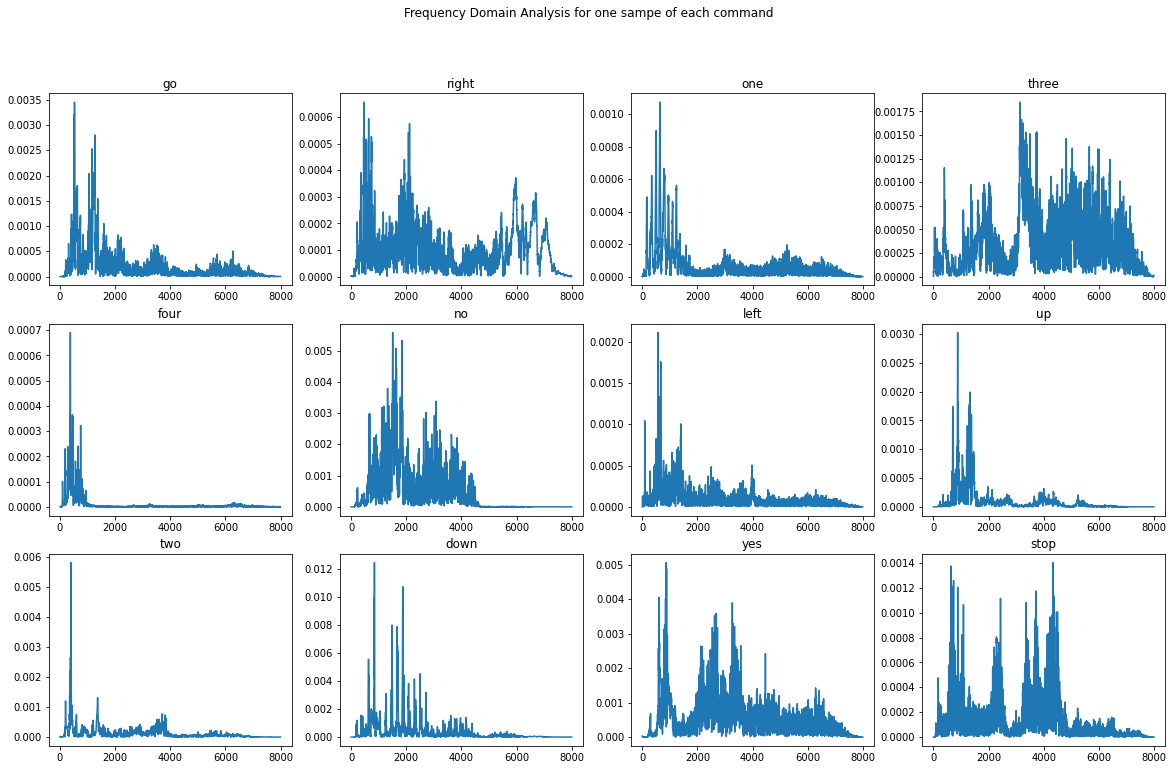

In [ ]:
# Frequency Domain Analysis (1 sample / command)

## Create grid for plotting 
rows = 3
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
fig.suptitle('Frequency Domain Analysis for one sampe of each command')

## Initialize seen labels in order to "extract" unique ones
seen_labels = [] 
i = 0;

# We will search for unique labels in 50 out of 26000 samples
search_samples = 50
pre_emphasis = 0.97 

## Search for unique labels and plot them into grid
for (audio, label) in waveform_ds.take(search_samples):
  
  if label not in seen_labels:
    # Applying pre-emphasis 
    audio = get_pre_emphasided(audio.numpy(),pre_emphasis)

    r = i // cols
    c = i % cols
    ax = axes[r][c]
    
    #Convert tensor to numpy 
    f, magn = get_fft(audio)
    ax.plot(f,magn)
    
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

    if len(seen_labels) == total_commands:
      break;

    seen_labels.append(label)
    i = i + 1 ; 

plt.show()

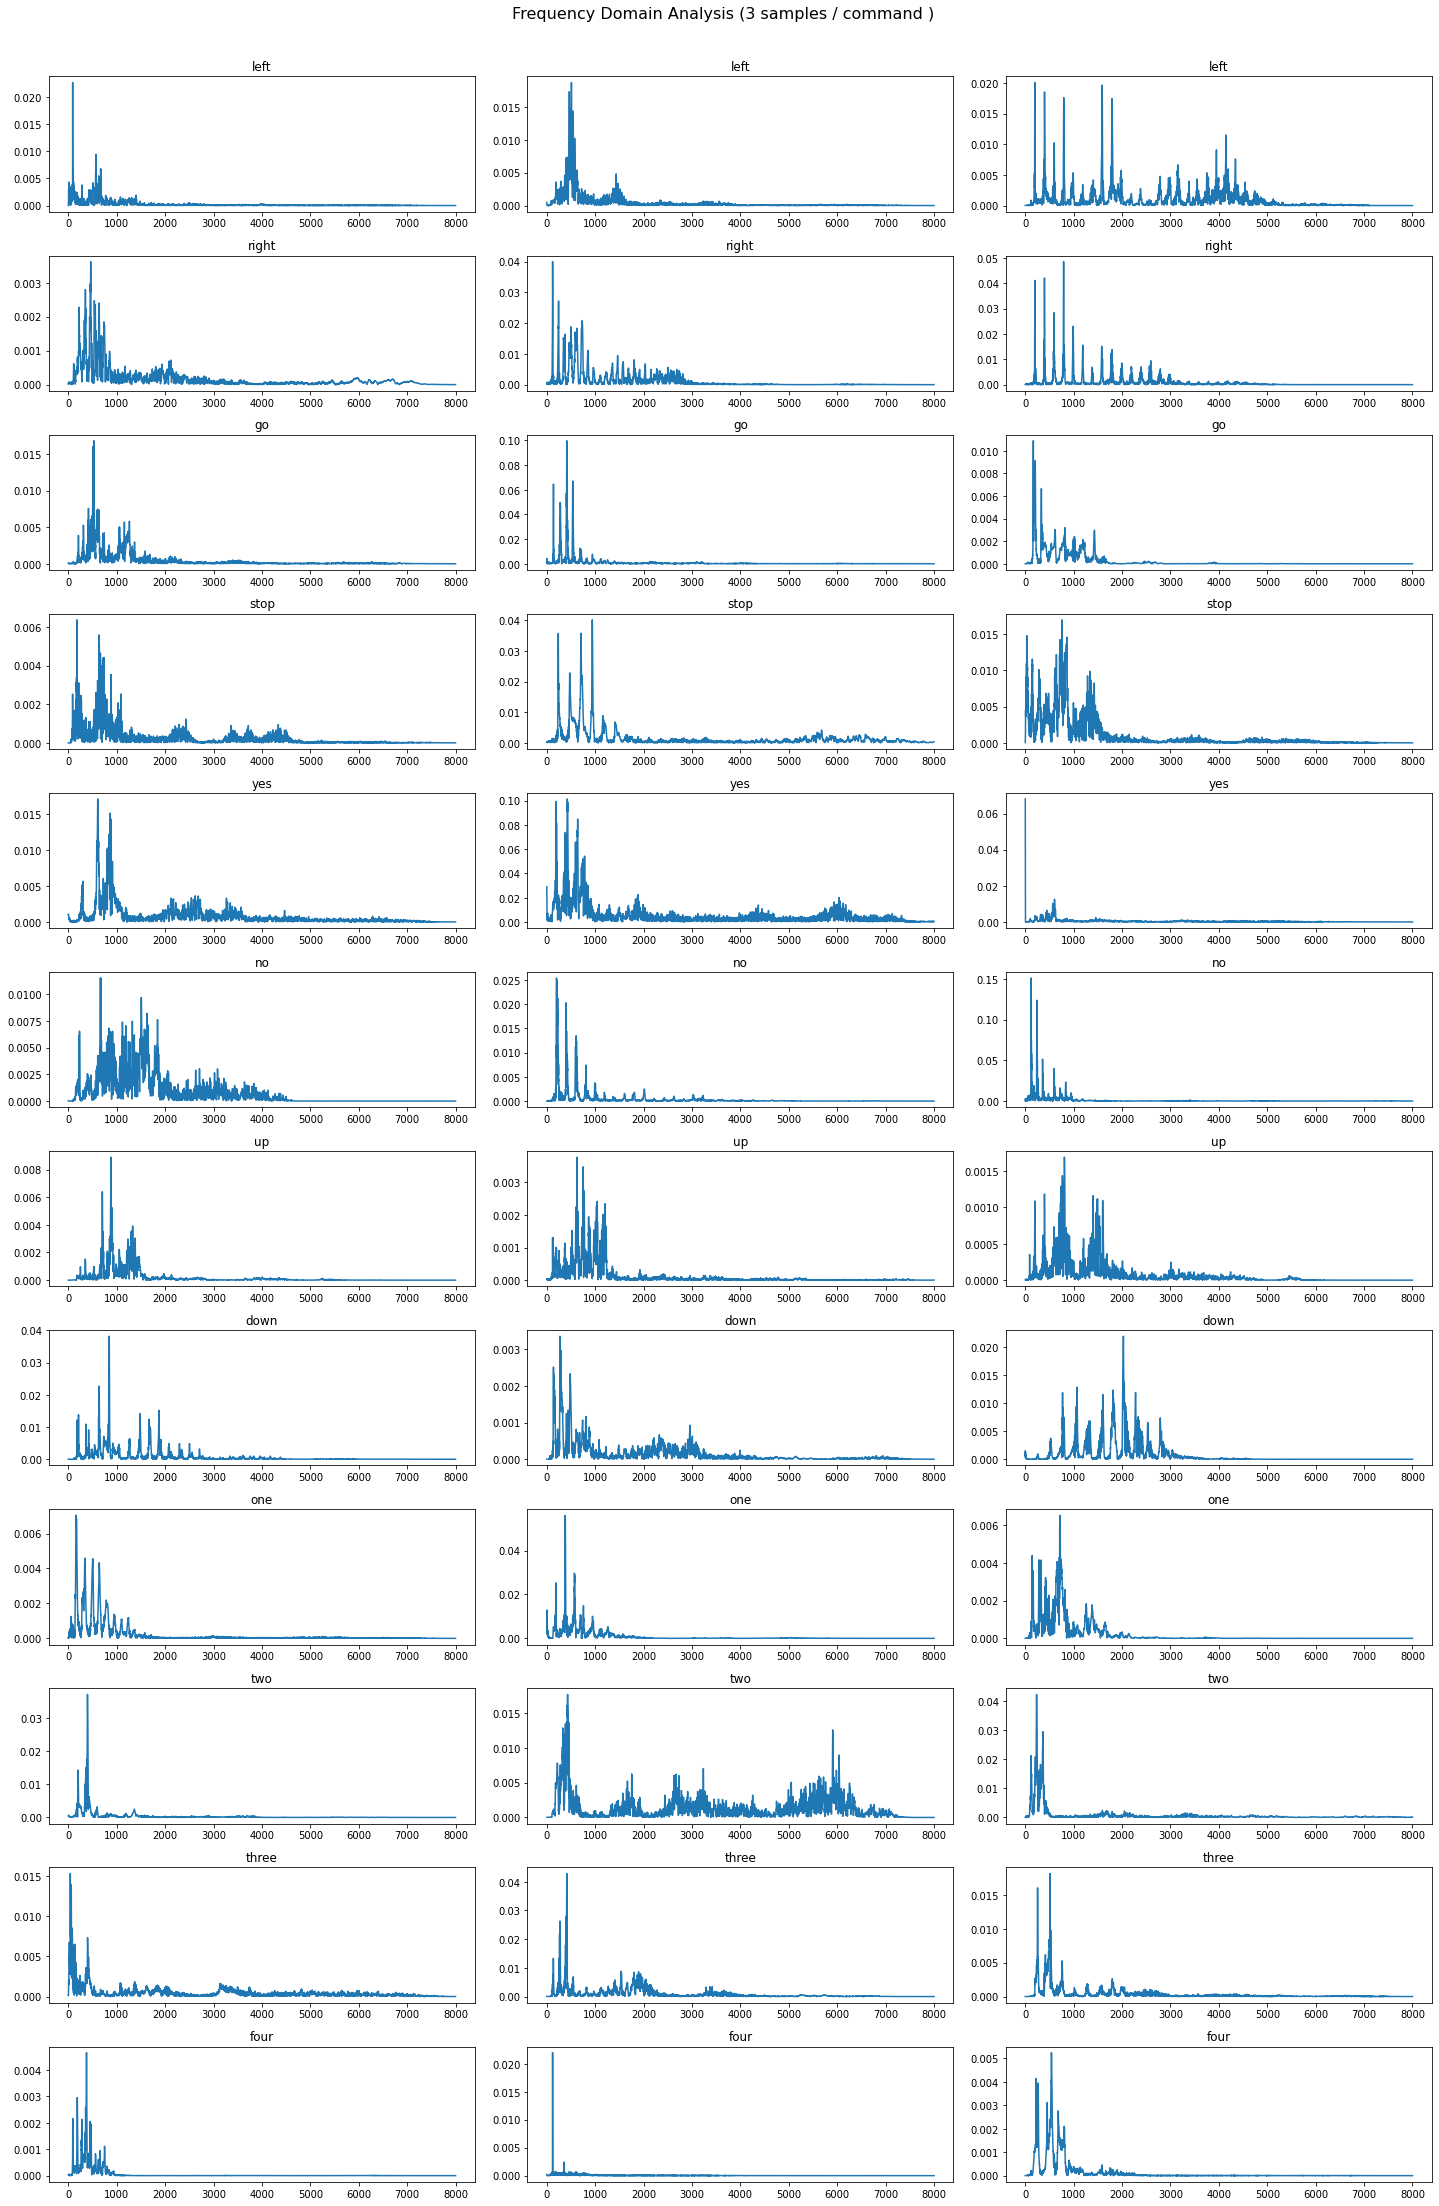

In [ ]:
# Frequency Domain Analysis (3 samples / command )

## Create grid for plotting 
rows = 12
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
fig.suptitle('Frequency Domain Analysis (3 samples / command )',y=1.02,fontsize=16)

## Initialize seen labels in order to "extract" unique ones
seen_labels = np.zeros(len(commands),dtype = 'int32')
i = 0;

# We will search for unique labels in 50 out of 26000 samples
search_samples = 100
pre_emphasis = 0.97 

## Search for unique labels and plot them into grid
for (audio, label) in waveform_ds.take(search_samples):
  id = tf.argmax(label == commands).numpy()
  if (seen_labels[id] <= 2):
    ax = axes[id][seen_labels[id]]
    seen_labels[id] = seen_labels[id] + 1 
    X,Y = get_fft(audio.numpy())
    ax.plot(X,Y)
    ax.set_title(commands[id])
    #ax.axis('off')

plt.tight_layout()
plt.show()

### Spectrogram Convertion

Spectrogram shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain

In [ ]:
#We count how many audio files need zero padding

'''
need_zero_pad = 0
for audio,_ in waveform_ds:
  if audio.numpy().shape[0] != 16000:
    need_zero_pad = need_zero_pad +1

print(need_zero_pad)

2251 / 28462 files need zero padding --> 0.08 % 
'''

'\nneed_zero_pad = 0\nfor audio,_ in waveform_ds:\n  if audio.numpy().shape[0] != 16000:\n    need_zero_pad = need_zero_pad +1\n\nprint(need_zero_pad)\n\n2251 / 28462 files need zero padding --> 0.08 % \n'

In [ ]:
def get_spectrogram(waveform):
  
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  
  # The STFT (tf.signal.stft) splits the signal into windows of time 
  # and runs a Fourier transform on each window

  frame_length = 255
  
  spectrogram = tf.signal.stft(
      equal_length, frame_length=frame_length, frame_step=128)

  ## FFT_SIZE = 255 
  ## 16000 / 128 = 125 windows

  # STFT produces an array of complex numbers representing magnitude and phase. 
  # However, we need only  the magnitude 
  

  # Has been replaced: Previous one was tf.abs(spectrogram)
  spectrogram = (1/frame_length)*tf.pow(tf.abs(spectrogram),2)

  ## Replace zero values with something else:
  ## With noise is no needed 

  spectrogram = tf.where(spectrogram > 0, spectrogram, 10**(-2))

  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(3):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

# Will be used after, plotting together mfcc's
temp_spec =spectrogram
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: one
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


(124, 129)


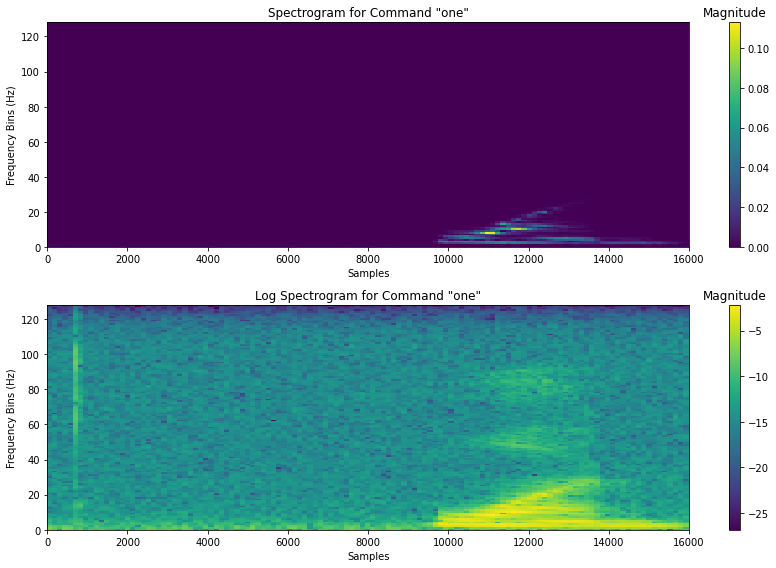

In [ ]:
def plot_spectrogram(spectrogram, ax, fig, logarithmic = True):

  # if logarithmic = True:
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  if logarithmic:
    spec = np.log(spectrogram.T)
  else:
    spec = spectrogram.T
  
  
  # log_spec.shape is (129,124)
  height = spec.shape[0]
  #height = 129
  X = np.arange(16000, step=height + 1)
  #[0, 130, 260, 390 ... ]
  # Y = 124
  Y = range(height)
  
  im = ax.pcolormesh(X, Y, spec)
  clb = fig.colorbar(im, ax=ax)
  clb.ax.set_title('Magnitude')
  



fig, axes = plt.subplots(2, figsize=(12, 8))
'''
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Waveform for Command "'+label+'"')
axes[0].set_xlim([0, 16000])
'''
plot_spectrogram(spectrogram.numpy(), axes[0], fig, logarithmic = False)
axes[0].set_title('Spectrogram for Command "'+label+'"')
axes[0].set_ylabel('Frequency Bins (Hz)')
axes[0].set_xlim([0, 16000])
axes[0].set_xlabel('Samples')

plot_spectrogram(spectrogram.numpy(), axes[1],fig )
axes[1].set_ylabel('Frequency Bins (Hz)')
axes[1].set_title('Log Spectrogram for Command "'+label+'"')
axes[1].set_xlim([0, 16000])
axes[1].set_xlabel('Samples')
print(spectrogram.numpy().shape)
plt.tight_layout()
plt.show()

In [ ]:
# Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

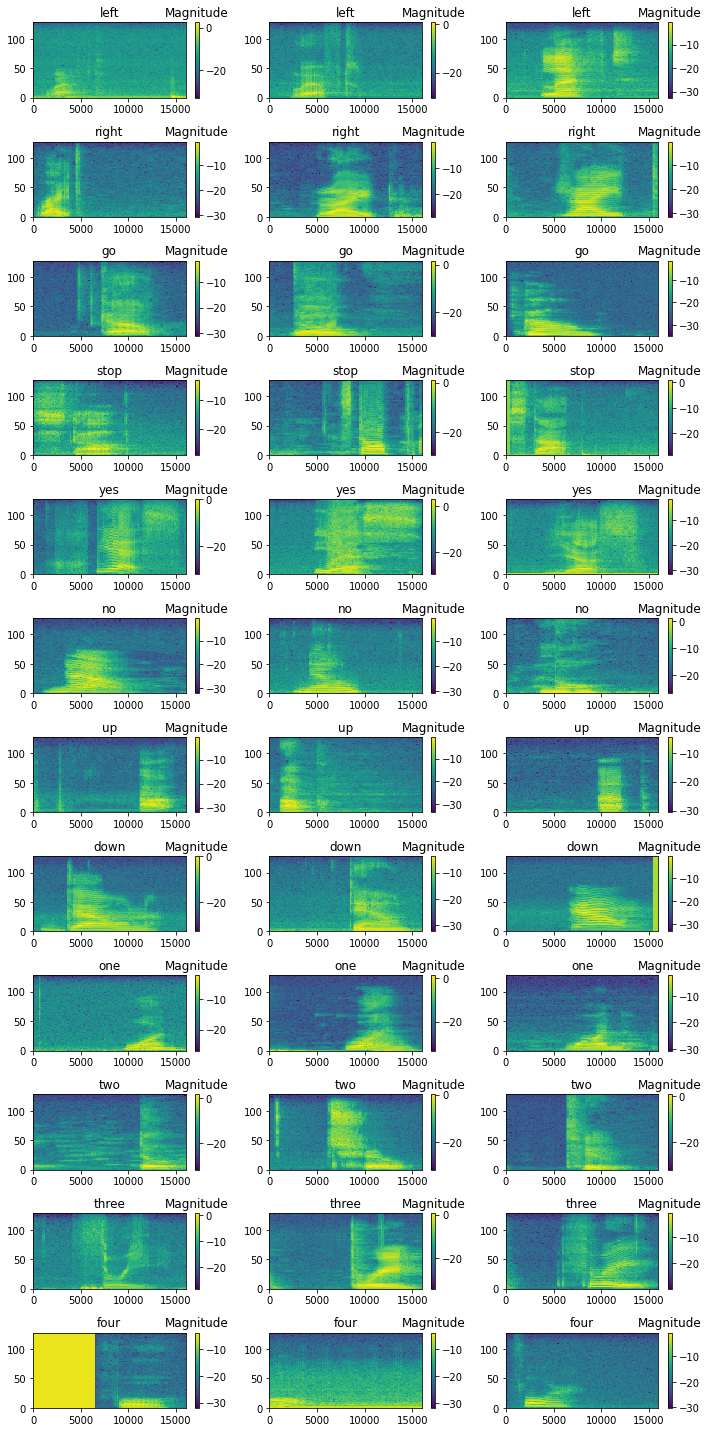

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
seen_labels = np.zeros(total_commands,dtype = int)

rows = total_commands
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 20))

# Search in 100 samples 
for (spectrogram, label_id) in spectrogram_ds.take(100):
  id = label_id.numpy()
  if (seen_labels[id] <= 2):
    ax = axes[id][seen_labels[id]]
    seen_labels[id] = seen_labels[id] + 1 
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax, fig)
    ax.set_title(commands[label_id.numpy()])
    #ax.axis('off')

plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()
#plt.figure(figsize=(10,4))
fig1.savefig('time.png')
files.download("time.png") 

### MFCC

In [ ]:
def get_mfcc(waveform):
  
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  
  # The STFT (tf.signal.stft) splits the signal into windows of time 
  # and runs a Fourier transform on each window
  frame_length = 255 
  stfts = tf.signal.stft(
      equal_length, frame_length=frame_length, frame_step=128)
  
  ## FFT_SIZE = 255
  ## 16000 / 128 = 125 windows

  # STFT produces an array of complex numbers representing magnitude and phase. 
  # However, we need only  the magnitude 
  
  spectr = (1/frame_length)*tf.pow(tf.abs(stfts),2)
  #spectrogram = tf.abs(stfts) PREVIOUS

  ## Replace zero values with something else:

  spectrograms = tf.where(spectr > 0, spectr, 10**(-2))
  sample_rate = 16000

  # So far we have just compute spectrogram (as get_spectrogram())
  # With the next commands, mfcc's are computed 
  

  # bins = FFT_SIZE/2 + 1 = 255/2 + 1 = 129
  num_spectrogram_bins = stfts.shape[-1]

  # min and max frequency in hertz (will be convertet to mel)
  # num_mel_bins = number of triangle filters 
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80

  #  linear_to_mel_weight_matrix: array M=(FFT_SIZE/2 + 1, #num_mel_bins)

  ## 1. lower_edge_hertz and upper_edge_hertz are converted from Hz to Mel 
  ## 2. The interval between these points is devided into (num_mel_bins+1) parts
  ## 3. Bounds of these parts are converted from Mel to Hz again 
  ## 4. These bounds are rounded to the nearest frequency bin
  ## 5. Triangle filters are constructed so as 
    ##  the left  bound of one filter being the center of previous one
    ##  the right bound of one filter being the center of next one (in Mels)

  ## So each Column is simply one triangle filter

  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
    upper_edge_hertz)
  
  #plt.plot(linear_to_mel_weight_matrix)

  # Remember: spectrogram is array Y = (#FRAMES, FFT_SIZE/2+1)
  mel_spectrograms = tf.tensordot(
    spectrograms, linear_to_mel_weight_matrix, 1)
    
  # So Mel_Spectrogram = Y*M 
  # = (#FRAMES, FFT_SIZE/2+1) * (#FFT_SIZE/2 + 1,#num_mel_bins) 
  # = (#FRAMES, #num_mel_bins)

  # spectrograms.shape[:-1] = #FRAMES
  # linear_to_mel_weight_matrix.shape[-1:] = #num_mel_bins

  #Ensures that shape is compatible 
  mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))
  
  # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
  # Mel_Spectrogram = log(Y*M) 
  log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

  # Compute MFCCs from log_mel_spectrograms and take the first 13.
  # For each frame (line), we compute DCT 
  # After this we keep 13 first columns thata are MFCC's
  mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
    log_mel_spectrograms)[..., :13]

  return mfccs

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  mfcc = get_mfcc(waveform)

temp_mfcc = mfcc
print(mfcc.shape)

(124, 13)


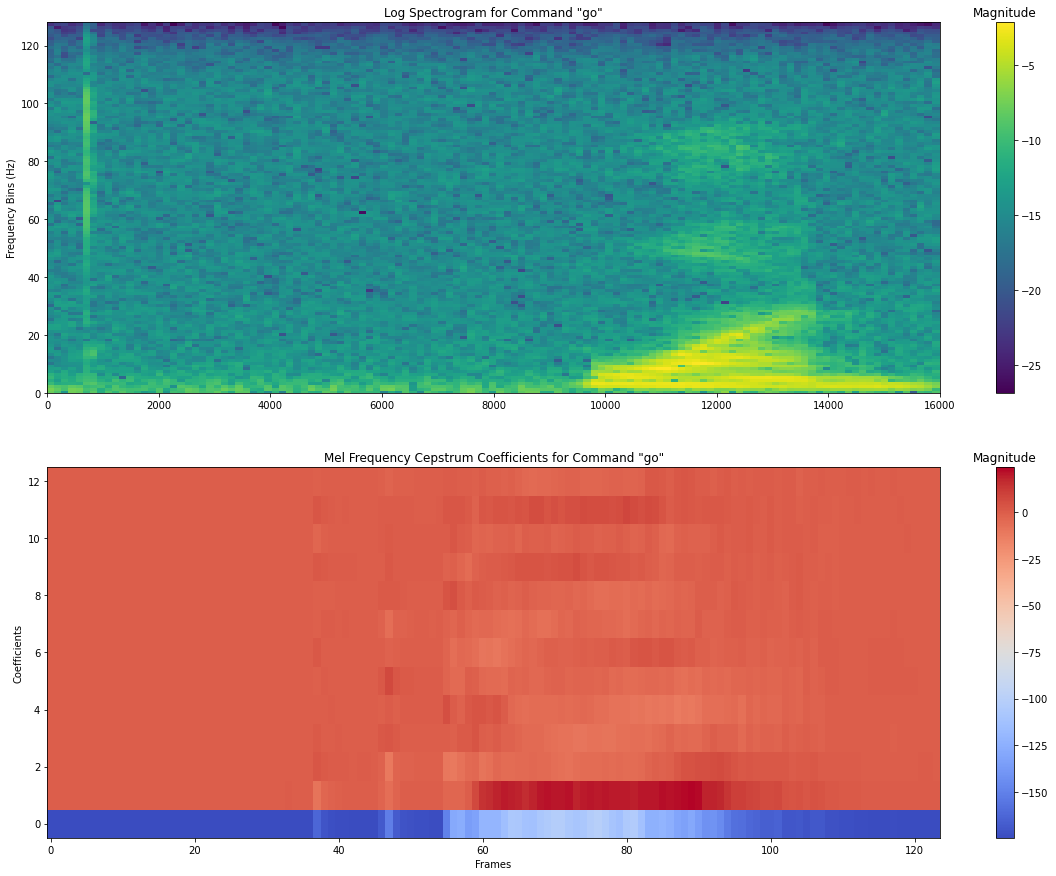

In [ ]:
def plot_mfcc(mfcc, ax, clrbar = False):
  mfcc_data= np.swapaxes(mfcc, 0 ,1)
  im = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
  if (clrbar == True):
    clb = fig.colorbar(im, ax=ax)
    clb.ax.set_title('Magnitude')
  


  


fig, axes = plt.subplots(2, figsize=(20, 15))

plot_spectrogram(temp_spec.numpy(), axes[0], fig)
axes[0].set_ylabel('Frequency Bins (Hz)')
axes[0].set_title('Log Spectrogram for Command "'+label+'"')
axes[0].set_xlim([0, 16000])



plot_mfcc(mfcc.numpy(), axes[1],clrbar = True)
axes[1].set_title('Mel Frequency Cepstrum Coefficients for Command "'+label+'"')
axes[1].set_xlabel('Frames')
axes[1].set_ylabel('Coefficients')

plt.show()

In [ ]:
# Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.
def get_mfcc_and_label_id(audio, label):
  mfcc = get_mfcc(audio)
  mfcc = tf.expand_dims(mfcc, -1)
  label_id = tf.argmax(label == commands)
  return mfcc, label_id

In [ ]:
mfcc_ds = waveform_ds.map(
    get_mfcc_and_label_id, num_parallel_calls=AUTOTUNE)

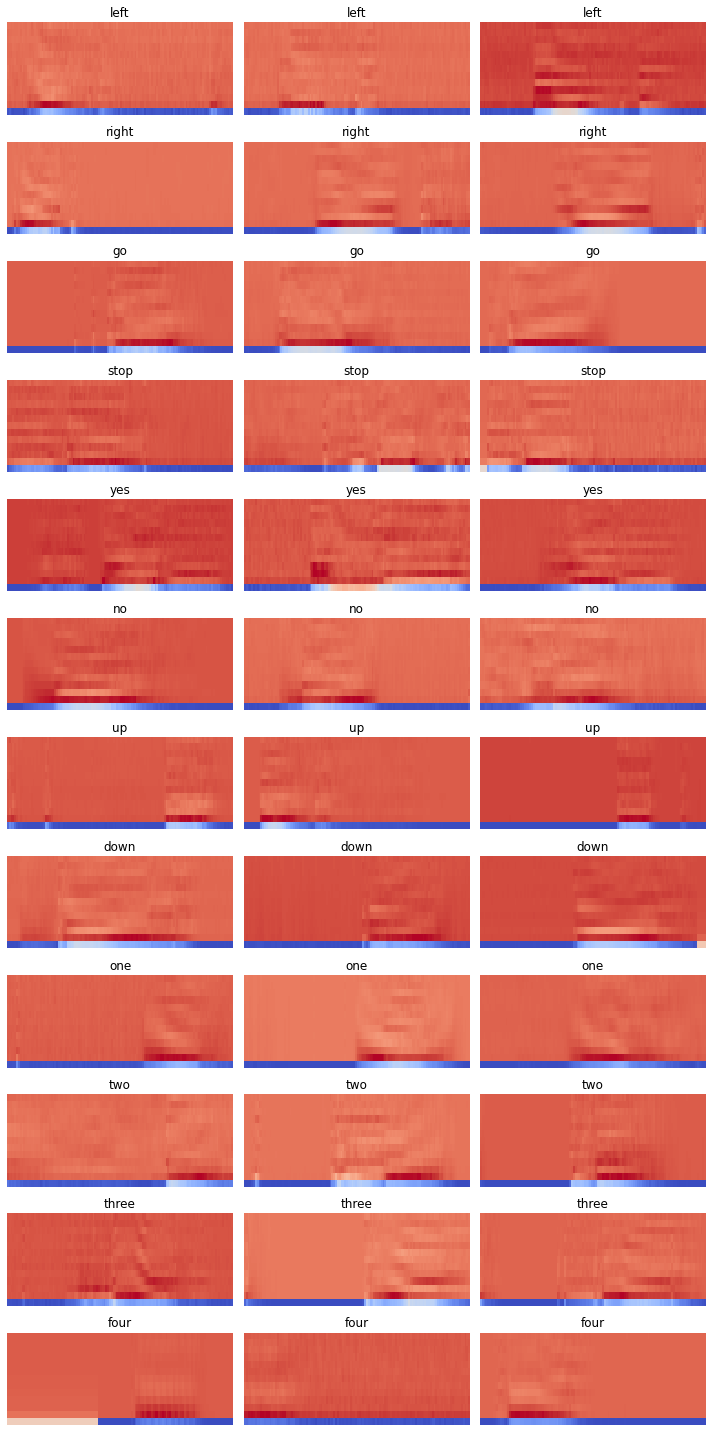

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
rows = total_commands
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 20))

seen_labels = np.zeros(total_commands,dtype = int)

# Search in 100 samples 
for (mfcc, label_id) in mfcc_ds.take(100):
  id = label_id.numpy()
  if (seen_labels[id] <= 2):
    ax = axes[id][seen_labels[id]]
    seen_labels[id] = seen_labels[id] + 1 
    plot_mfcc(np.squeeze(mfcc.numpy()), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

#plt.show()


plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()
#plt.figure(figsize=(10,4))
fig1.savefig('time.png')
files.download("time.png") 

### MFCC's delta



*   N = 1 : delta mfccs 
*   N = 2 : delta delta mfccs




In [ ]:
N = 1 
# N = 2

In [ ]:
def get_delta_mfccs(mfccs, N=1):  
  #For each frame, calculate delta features 
  #based on preceding and following N frames
  numframes = len(mfccs)
  coefficients = mfccs.shape[1]

  # Shape of mfcc's is (numframes,coefficients,1)
  # so is turned to (numframes,coefficients)
  mfccs = tf.reshape(mfccs,[numframes,coefficients])

  #Padding edge values of mfcc's vertically 
  paddings_1 = tf.constant([[N, 0,], [0, 0]])
  padded_mfccs_1 = tf.pad(mfccs, paddings_1, "SYMMETRIC")
  x1 = -N * padded_mfccs_1[:-N]

  #Padding edge values of mfcc's vertically 
  paddings_2 = tf.constant([[N-1, 0,], [0, 0]])
  padded_mfccs_2 = tf.pad(mfccs, paddings_2, "SYMMETRIC")  
  x2 = -(N-1) * padded_mfccs_2[:-(N-1)]

  #Padding edge values of mfcc's vertically 
  paddings_3 = tf.constant([[0, N-1,], [0, 0]])
  padded_mfccs_3 = tf.pad(mfccs, paddings_3, "SYMMETRIC")  
  x3 = (N-1)* padded_mfccs_3[N-1:]

  #Padding edge values of mfcc's vertically 
  paddings_4 = tf.constant([[0, N,], [0, 0]])
  padded_mfccs_4 = tf.pad(mfccs, paddings_4, "SYMMETRIC")  
  x4 = N * padded_mfccs_4[N:]


  denominator = 2 * sum([i**2 for i in range(1, N+1)])

  if (N == 2):
    print('delta - delta ')
    delta_features = (x1+x2+x3+x4) / denominator
  if (N == 1):
    delta_features = (x1+x4) / denominator
    print('delta')
  return delta_features

In [ ]:
N = 1 
for mfcc, label in mfcc_ds.take(5):
  label = commands[label.numpy()]
  delta_mfcc = get_delta_mfccs(mfcc,1)
  delta_delta_mfcc = get_delta_mfccs(mfcc,2)

print(delta_mfcc.shape)
print(delta_delta_mfcc.shape)

delta
delta - delta 
delta
delta - delta 
delta
delta - delta 
delta
delta - delta 
delta
delta - delta 
(124, 13)
(124, 13)


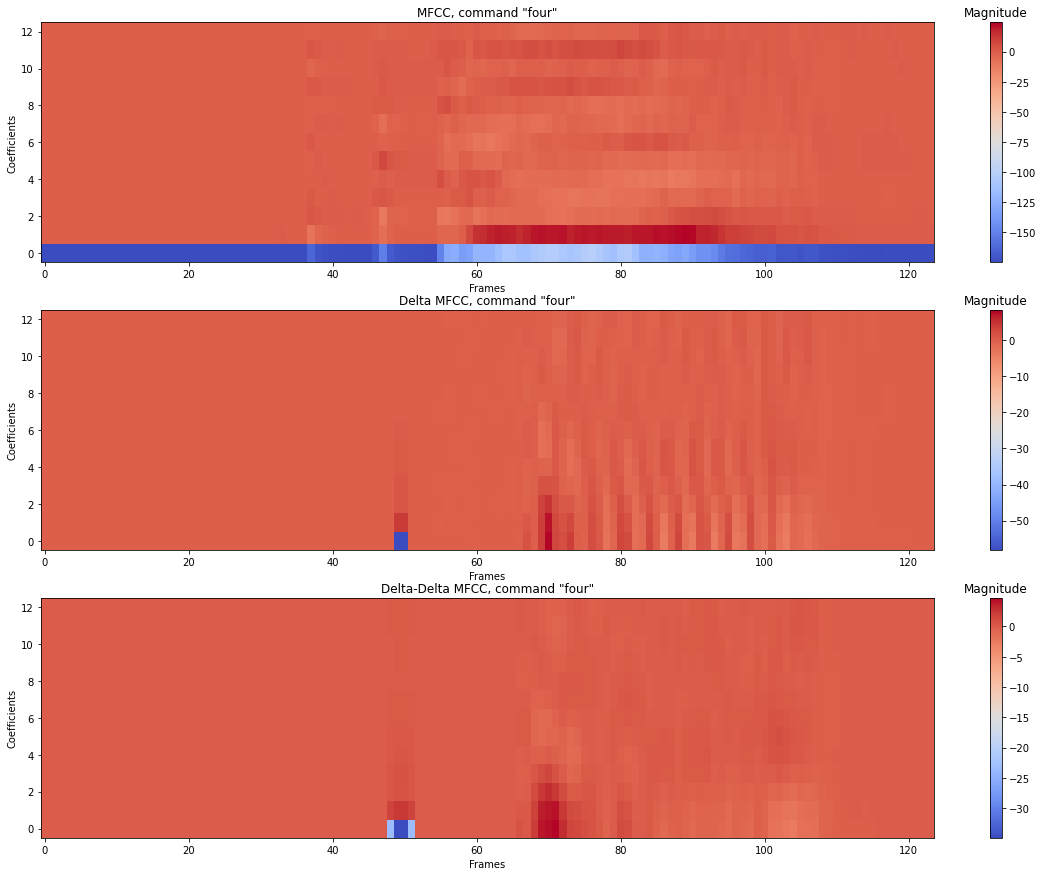

In [ ]:
def plot_delta_mfccs(delta_mfccs,ax,clrbar = False):
  mfcc_data= np.swapaxes(delta_mfccs, 0 ,1)
  im = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
  if (clrbar == True):
    clb = fig.colorbar(im, ax=ax)
    clb.ax.set_title('Magnitude')
  
fig, axes = plt.subplots(3, figsize=(20, 15))

plot_mfcc(temp_mfcc.numpy(), axes[0],clrbar = True)
axes[0].set_title('MFCC, command "'+label+'"')
axes[0].set_xlabel('Frames')
axes[0].set_ylabel('Coefficients')

plot_delta_mfccs(delta_mfcc.numpy(), axes[1],clrbar = True)
axes[1].set_title('Delta MFCC, command "'+label+'"')
axes[1].set_xlabel('Frames')
axes[1].set_ylabel('Coefficients')


plot_delta_mfccs(delta_delta_mfcc.numpy(), axes[2],clrbar = True)
axes[2].set_title('Delta-Delta MFCC, command "'+label+'"')
axes[2].set_xlabel('Frames')
axes[2].set_ylabel('Coefficients')

plt.show()

In [ ]:
# Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.
def get_delta_mfcc_and_label_id(mfcc, label):
  delta_mfcc = get_delta_mfccs(mfcc)
  delta_mfcc = tf.expand_dims(delta_mfcc, -1)
  #label_id = tf.argmax(label == commands)
  return delta_mfcc, label

In [ ]:
delta_mfcc_ds = mfcc_ds.map(
    get_delta_mfcc_and_label_id, num_parallel_calls=AUTOTUNE)

delta


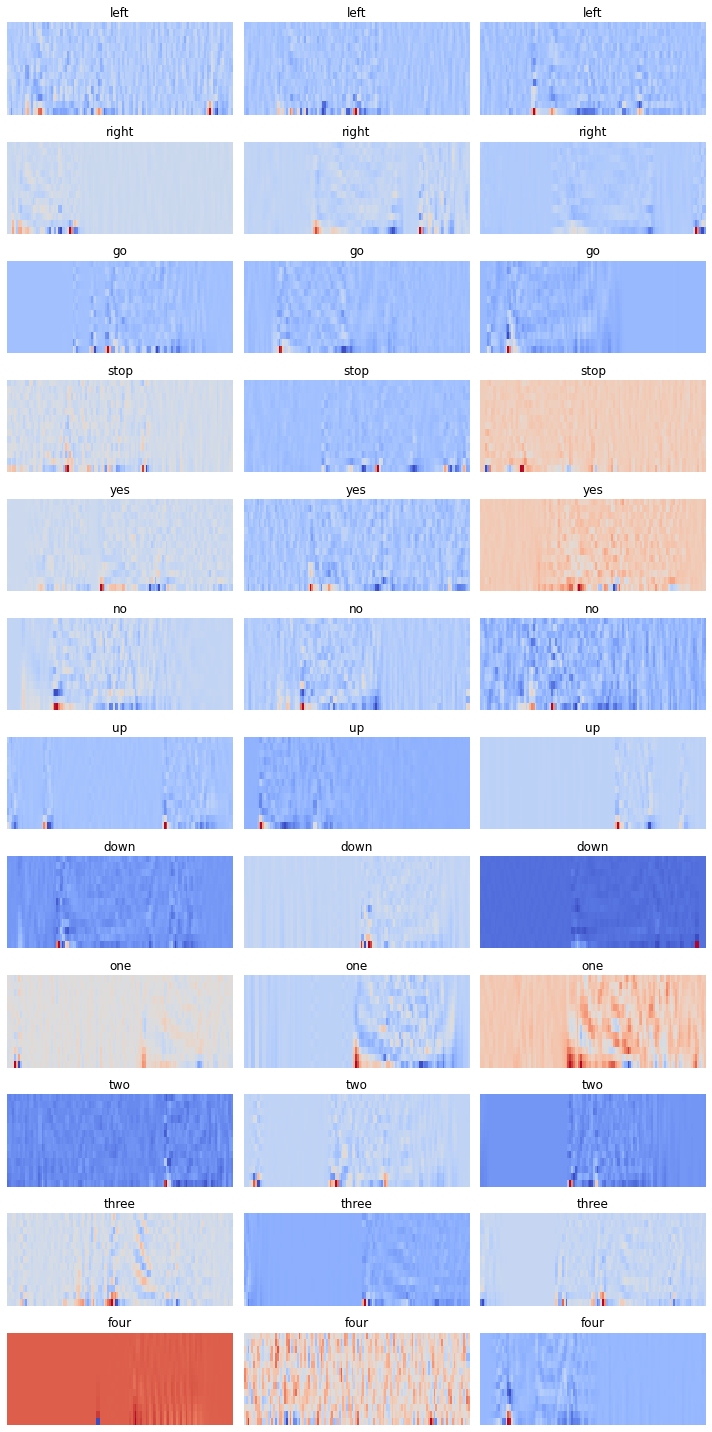

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
rows = total_commands
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 20))

seen_labels = np.zeros(total_commands,dtype = int)

# Search in 100 samples 
for (delta_mfcc, label_id) in delta_mfcc_ds.take(100):
  id = label_id.numpy()
  if (seen_labels[id] <= 2):
    ax = axes[id][seen_labels[id]]
    seen_labels[id] = seen_labels[id] + 1 
    plot_delta_mfccs(np.squeeze(delta_mfcc.numpy()), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

#plt.show()


plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()
#plt.figure(figsize=(10,4))
fig1.savefig('delta.png')
files.download("delta.png") 

## Data pre-processing

In this stage it is necessary to determine features 

In [ ]:
FEAT = "mfcc" #/ "mfcc" / "spectrogram" / "delta_mfcc" (N = 1 or N = 2 )" 

In [ ]:
## Repeat the training set preprocessing on the validation and test sets.
def preprocess_dataset(files,FEAT):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  
  if (FEAT == "spectrogram" ):
    output_ds = output_ds.map(get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  elif (FEAT == "mfcc" ):
    output_ds = output_ds.map(get_mfcc_and_label_id,  num_parallel_calls=AUTOTUNE)
  #new
  elif (FEAT == "delta_mfcc"):
    
    mfcc_ds = output_ds.map(get_mfcc_and_label_id,  num_parallel_calls=AUTOTUNE)
    output_ds = mfcc_ds.map(get_delta_mfcc_and_label_id,  num_parallel_calls=AUTOTUNE) 
    
  return output_ds

In [ ]:
if (FEAT == "spectrogram" ):
  train_ds = spectrogram_ds
elif (FEAT == "mfcc"):
  train_ds = mfcc_ds
#new
elif (FEAT == "delta_mfcc"):
  train_ds = delta_mfcc_ds


val_ds = preprocess_dataset(val_files,FEAT)
test_ds = preprocess_dataset(test_files,FEAT)

In [ ]:
## Batch the training and validation sets for model training.

if FEAT == "mfcc":
  batch_size = 64 
elif FEAT == "spectrogram":
  batch_size = 64
#new
elif FEAT == "delta_mfcc":
  batch_size = 64


train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)


## Reduce read latency while training the model.
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
if FEAT == "spectrogram":
  for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape

elif FEAT == "mfcc":
  for mfcc, _ in mfcc_ds.take(1):
    input_shape = mfcc.shape

#new
elif FEAT == "delta_mfcc":
  for delta_mfcc, _ in delta_mfcc_ds.take(1):
    input_shape = delta_mfcc.shape



print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (124, 13, 1)


## Build and train the models

In [ ]:
#Normalization Layer (About 1:15 h)
norm_layer = preprocessing.Normalization()

if (FEAT == "spectrogram"):
  norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))
elif (FEAT == "mfcc"):
    norm_layer.adapt(mfcc_ds.map(lambda x, _: x))
elif (FEAT == "delta_mfcc"):
    norm_layer.adapt(delta_mfcc_ds.map(lambda x, _: x))

### Model 1 (Simple CNN)

#### MFCC (optimized)

In [ ]:
print(FEAT)

mfcc


##### Define Model

In [ ]:
from keras.regularizers import l2
model_1 = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_8 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 12544)            

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_3 (Dense)              (None, 12)               

No handles with labels found to put in legend.


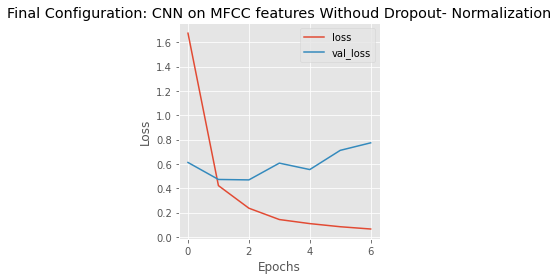

In [ ]:
from keras.regularizers import l2
model_1 = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    #norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    #layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_1.summary()

# from_logits = True 
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)

callbacks_list = [checkpoint, early_stopping]

EPOCHS = 30
history = model_1.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=callbacks_list ,
)

plt.style.use("ggplot")
metrics = history.history

fig1 = plt.gcf()
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.title("Final Configuration: CNN on MFCC features Withoud Dropout- Normalization")
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()


fig1.savefig('final.png')

In [ ]:
# from_logits = True 
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
#model_1.save('dense.h5')

In [ ]:
# | Epochs | Time (min) | Val Acc (%) |
# |    5   |     23     |    86.02    | 
# |    10  |     fst    |    88.8     | 
 
EPOCHS = 30
history = model_1.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=callbacks_list ,
)

Epoch 1/30
356/356 [==============================] - 5s 11ms/step - loss: 1.9675 - accuracy: 0.3172 - val_loss: 1.2566 - val_accuracy: 0.6156

Epoch 00001: val_accuracy improved from -inf to 0.61560, saving model to weights.best.hdf5
Epoch 2/30
356/356 [==============================] - 4s 11ms/step - loss: 1.3091 - accuracy: 0.5572 - val_loss: 0.8116 - val_accuracy: 0.7663

Epoch 00002: val_accuracy improved from 0.61560 to 0.76634, saving model to weights.best.hdf5
Epoch 3/30
356/356 [==============================] - 4s 10ms/step - loss: 1.0200 - accuracy: 0.6568 - val_loss: 0.6340 - val_accuracy: 0.8029

Epoch 00003: val_accuracy improved from 0.76634 to 0.80288, saving model to weights.best.hdf5
Epoch 4/30
356/356 [==============================] - 4s 11ms/step - loss: 0.8655 - accuracy: 0.7077 - val_loss: 0.5410 - val_accuracy: 0.8331

Epoch 00004: val_accuracy improved from 0.80288 to 0.83310, saving model to weights.best.hdf5
Epoch 5/30
356/356 [==============================]

No handles with labels found to put in legend.


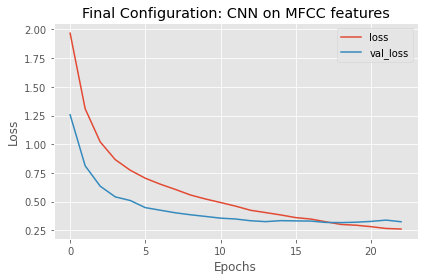

In [ ]:
plt.style.use("ggplot")
metrics = history.history

fig1 = plt.gcf()
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.title("Final Configuration: CNN on MFCC features")
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()


fig1.savefig('final.png')

##### Evaluate Model

In [ ]:
path = '/content/drive/MyDrive/my_project/saved_weights/CNNonMFCC/weights.best.hdf5'

In [ ]:
model_1.load_weights(path)

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model_1.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.1%}')

Test set accuracy: 90.3%


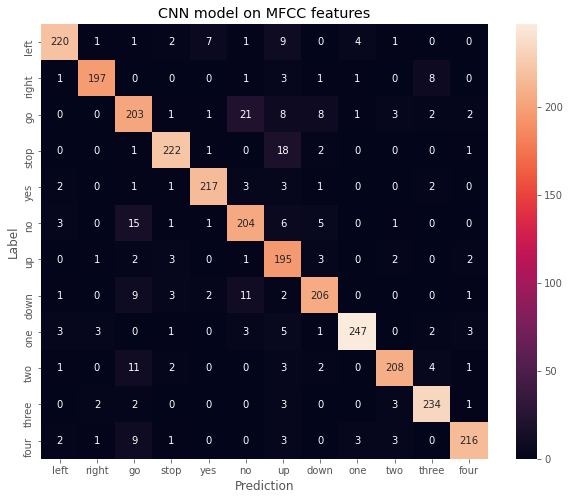

<Figure size 432x288 with 0 Axes>

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 

plt.figure(figsize=(10, 8))

fig2 = plt.gcf()
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.title("CNN model on MFCC features")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
plt.draw()

fig2.savefig('conf.png')

#### SPECTROGRAM

`Resizing layer`:downsample the input to enable the model to train faster. <br/>
`Normalization layer`: normalize each pixel in the image based on its mean and standard deviation

In [ ]:
print(FEAT)

spectrogram


##### Define Model

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)            

In [ ]:
# from_logits=True 
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
# | Epochs | Time (min) | Val Acc (%) |
# |    5   |     12     |    69.8     | False
# |    10  |      1     |    ????     | False
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
356/356 [==============================] - 3s 6ms/step - loss: 2.2131 - accuracy: 0.2413 - val_loss: 1.7716 - val_accuracy: 0.4209
Epoch 2/10
356/356 [==============================] - 2s 6ms/step - loss: 1.6926 - accuracy: 0.4236 - val_loss: 1.4085 - val_accuracy: 0.5257
Epoch 3/10
356/356 [==============================] - 2s 6ms/step - loss: 1.4078 - accuracy: 0.5257 - val_loss: 1.2080 - val_accuracy: 0.6131
Epoch 4/10
356/356 [==============================] - 2s 6ms/step - loss: 1.2245 - accuracy: 0.5835 - val_loss: 1.0515 - val_accuracy: 0.6648
Epoch 5/10
356/356 [==============================] - 2s 6ms/step - loss: 1.0914 - accuracy: 0.6288 - val_loss: 0.9492 - val_accuracy: 0.6996
Epoch 6/10
356/356 [==============================] - 2s 6ms/step - loss: 1.0015 - accuracy: 0.6581 - val_loss: 0.8963 - val_accuracy: 0.7140
Epoch 7/10
356/356 [==============================] - 2s 6ms/step - loss: 0.9237 - accuracy: 0.6840 - val_loss: 0.8278 - val_accuracy: 0.7351
Epoch 

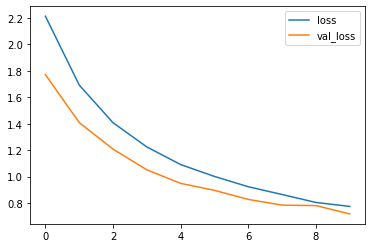

In [ ]:
plt.style.use("ggplot")
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()

##### Evaluate model

In [ ]:
# 5min
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 77%


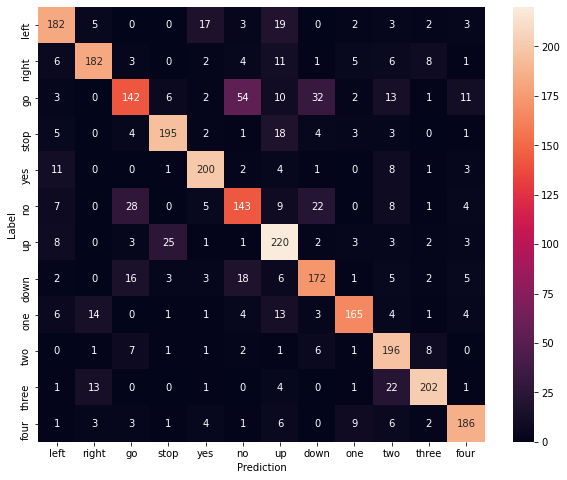

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


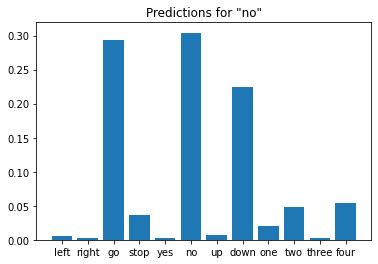

In [ ]:
sample_file = data_dir+'/no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)],FEAT)

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()


##### Save model

In [ ]:
path = '/content/drive/MyDrive/Thesis_George_Giannios/models/simple_cnn'
os.mkdir(path)

model.save(path) 

In [ ]:
#!mkdir -p saved_model

In [ ]:
#model.save('saved_model/my_model') 

In [ ]:
new_model = tf.keras.models.load_model(path)

In [ ]:
new_model.summary()

#### DELTA - MFCC

In [ ]:
print(FEAT)

delta_mfcc


##### Define Model

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                3

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
# | Epochs | Time (min) | Val Acc (%) |
# |    5   |     12     |    23.6     |
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
356/356 [==============================] - 1s 4ms/step - loss: 1.9584 - accuracy: 0.3056 - val_loss: 1.6627 - val_accuracy: 0.4993
Epoch 2/10
356/356 [==============================] - 1s 4ms/step - loss: 1.8615 - accuracy: 0.3312 - val_loss: 1.5591 - val_accuracy: 0.5260
Epoch 3/10
356/356 [==============================] - 1s 3ms/step - loss: 1.8003 - accuracy: 0.3557 - val_loss: 1.4948 - val_accuracy: 0.5467
Epoch 4/10
356/356 [==============================] - 1s 3ms/step - loss: 1.7535 - accuracy: 0.3773 - val_loss: 1.4466 - val_accuracy: 0.5566
Epoch 5/10
356/356 [==============================] - 1s 3ms/step - loss: 1.7126 - accuracy: 0.3897 - val_loss: 1.4099 - val_accuracy: 0.5650
Epoch 6/10
356/356 [==============================] - 1s 3ms/step - loss: 1.6744 - accuracy: 0.3998 - val_loss: 1.3666 - val_accuracy: 0.5843
Epoch 7/10
356/356 [==============================] - 1s 3ms/step - loss: 1.6367 - accuracy: 0.4158 - val_loss: 1.3405 - val_accuracy: 0.5861
Epoch 

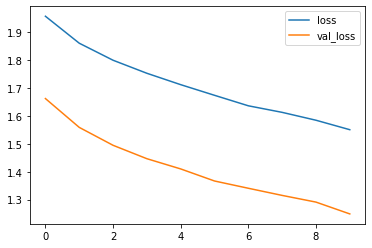

In [ ]:
plt.style.use("ggplot")
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()

##### Evaluate Model

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 62%


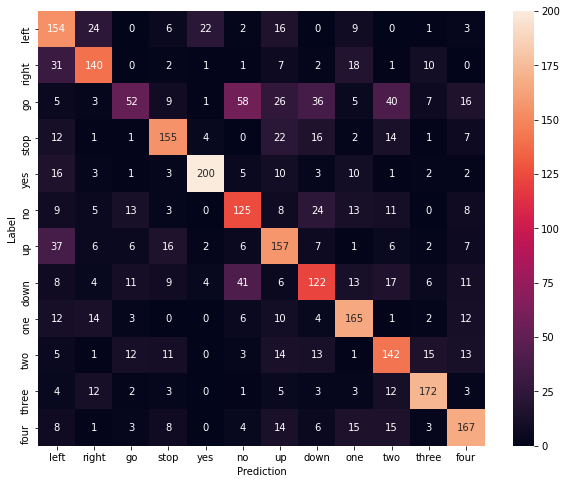

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Model 2 (Combined CNN-RNN)

#### MFCC (optimized)

In [ ]:
print(FEAT)

mfcc


##### Define Model <br/>
Source : [Stack Overflow](https://stackoverflow.com/questions/52032312/how-to-connect-rnn-at-the-end-of-a-cnn-to-use-to-train-video-frames)

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Reshape((64, -1)),
    layers.Permute((2,1)),
    layers.SimpleRNN(64, activation='relu'),
    #layers.LSTM(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels,activation = 'softmax'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 64, 196)          

In [ ]:
# from_logits = True | from_logits = False
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [ ]:
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="/content/drive/MyDrive/my_project/saved_weights/weights.best.hdf5" 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
# | Epochs | Time (min) | Val Acc (%) |
# |    10  |     22     |    77.6     | True
# |    10  |     27     |    78.0     | False
EPOCHS = 30
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks= callbacks_list,
)

Epoch 1/30
356/356 [==============================] - 85s 235ms/step - loss: 2.3688 - accuracy: 0.1589 - val_loss: 1.9400 - val_accuracy: 0.3507

Epoch 00001: val_accuracy improved from -inf to 0.35067, saving model to /content/drive/MyDrive/Thesis_George_Giannios/saved_weights/weights.best.hdf5
Epoch 2/30
356/356 [==============================] - 83s 234ms/step - loss: 1.8992 - accuracy: 0.3335 - val_loss: 1.5774 - val_accuracy: 0.4912

Epoch 00002: val_accuracy improved from 0.35067 to 0.49122, saving model to /content/drive/MyDrive/Thesis_George_Giannios/saved_weights/weights.best.hdf5
Epoch 3/30
356/356 [==============================] - 84s 236ms/step - loss: 1.6886 - accuracy: 0.4137 - val_loss: 1.4109 - val_accuracy: 0.5559

Epoch 00003: val_accuracy improved from 0.49122 to 0.55587, saving model to /content/drive/MyDrive/Thesis_George_Giannios/saved_weights/weights.best.hdf5
Epoch 4/30
356/356 [==============================] - 84s 235ms/step - loss: 1.5706 - accuracy: 0.4626 

In [ ]:
plt.style.use("ggplot")
metrics = history.history

fig1 = plt.gcf()
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.title("CNN followed by 64 RNN units")
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()

fig1.savefig('cnn_rnn64.png')

##### Evaluate Model

In [ ]:
# 1 min
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 


plt.figure(figsize=(10, 8))

fig2 = plt.gcf()
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.title("CNN-RNN model on MFCC features")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
plt.draw()

fig2.savefig('CNN-RNN-64.png')

#### SPECTROGRAM

In [ ]:
print(FEAT)

spectrogram


##### Define Model <br/>
Source : [Stack Overflow](https://stackoverflow.com/questions/52032312/how-to-connect-rnn-at-the-end-of-a-cnn-to-use-to-train-video-frames)

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Reshape((64, -1)),
    layers.Permute((2,1)),
    layers.SimpleRNN(128, activation='relu'),
    #layers.LSTM(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels,activation = 'softmax'),
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 196)          

In [ ]:
# from_logits=True or False
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [ ]:
# | Epochs | Time (min) | Val Acc (%) |
# |    5   |     6      |    30.9     |
# |    10  |     12     |    46.3     |
# 1 37 
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/10
356/356 [==============================] - 59s 163ms/step - loss: 2.4335 - accuracy: 0.1260 - val_loss: 2.2614 - val_accuracy: 0.1799
Epoch 2/10
356/356 [==============================] - 57s 160ms/step - loss: 2.2680 - accuracy: 0.1821 - val_loss: 2.1491 - val_accuracy: 0.2407
Epoch 3/10
356/356 [==============================] - 57s 159ms/step - loss: 2.1907 - accuracy: 0.2148 - val_loss: 2.0525 - val_accuracy: 0.2681
Epoch 4/10
356/356 [==============================] - 58s 163ms/step - loss: 2.1276 - accuracy: 0.2422 - val_loss: 2.0030 - val_accuracy: 0.2962
Epoch 5/10
356/356 [==============================] - 58s 163ms/step - loss: 2.0541 - accuracy: 0.2716 - val_loss: 1.9121 - val_accuracy: 0.3208
Epoch 6/10
356/356 [==============================] - 58s 162ms/step - loss: 1.9681 - accuracy: 0.3034 - val_loss: 1.8020 - val_accuracy: 0.3563
Epoch 7/10
356/356 [==============================] - 58s 164ms/step - loss: 1.8955 - accuracy: 0.3283 - val_loss: 1.7479 - val_ac

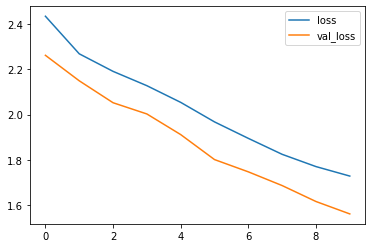

In [ ]:
plt.style.use("ggplot")
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()

##### Evaluate Model

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 44%


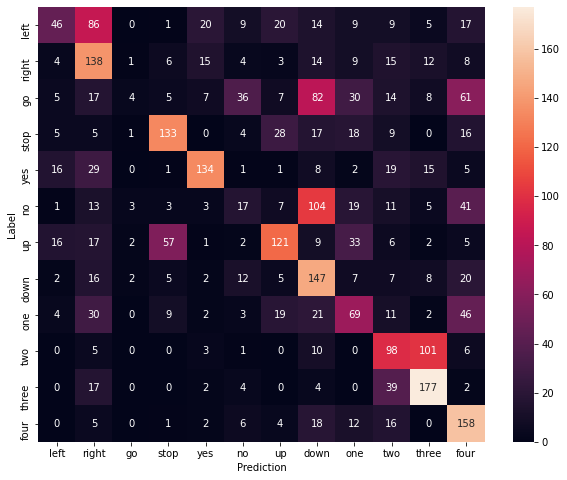

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

#### DELTA - MFCC

In [ ]:
print(FEAT)

delta_mfcc


##### Define Model <br/>
Source : [Stack Overflow](https://stackoverflow.com/questions/52032312/how-to-connect-rnn-at-the-end-of-a-cnn-to-use-to-train-video-frames)

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Reshape((32, -1)),
    layers.Permute((2,1)),
    layers.SimpleRNN(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels,activation = 'softmax'),
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 392)          

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)],
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


356/356 [==============================] - 515s 1s/step - loss: 2.4586 - accuracy: 0.1192 - val_loss: 2.3868 - val_accuracy: 0.1620
Epoch 2/10
356/356 [==============================] - 168s 471ms/step - loss: 2.2799 - accuracy: 0.2008 - val_loss: 2.0755 - val_accuracy: 0.2927
Epoch 3/10
356/356 [==============================] - 165s 464ms/step - loss: 2.0777 - accuracy: 0.2743 - val_loss: 1.8793 - val_accuracy: 0.3507
Epoch 4/10
356/356 [==============================] - 165s 464ms/step - loss: 1.9601 - accuracy: 0.3135 - val_loss: 1.7581 - val_accuracy: 0.4058
Epoch 5/10
356/356 [==============================] - 166s 467ms/step - loss: 1.8644 - accuracy: 0.3478 - val_loss: 1.6668 - val_accuracy: 0.4473
Epoch 6/10
356/356 [==============================] - 166s 467ms/step - loss: 1.8023 - accuracy: 0.3725 - val_loss: 1.5971 - val_accuracy: 0.4733
Epoch 7/10
356/356 [==============================] - 168s 471ms/step - loss: 1.7402 - accuracy: 0.3977 - val_loss: 1.5728 - val_accuracy:

No handles with labels found to put in legend.


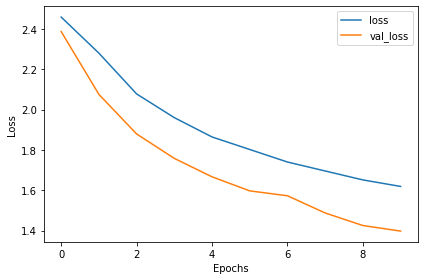

In [ ]:
plt.style.use("ggplot")
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()


##### Evaluate Model

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 53%


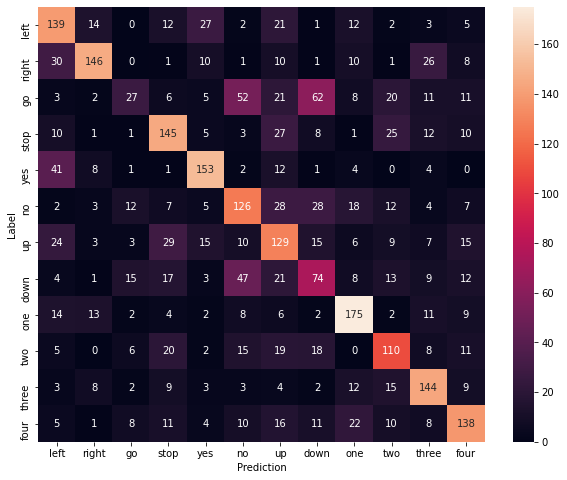

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Model 3 (Transfer Learning) 

#### MFCC

In [ ]:
print(FEAT)

mfcc


##### Define model

[Phg](http://5.9.10.113/66863736/tensorflow-keras-use-mobilenetv2-model-with-inputs-less-than-32x32)

In [ ]:
def init_RESNET_model(summary):

  input_s = layers.Input((124,13,1))
  
  resnet_model=tf.keras.applications.ResNet50(input_tensor = input_s, include_top=False,weights = None)
  
  RESNET_MODEL=resnet_model.layers[0](resnet_model)

  # unfreeze conv layers
  RESNET_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(12,activation='softmax')
  model = tf.keras.Sequential([RESNET_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model


In [ ]:
transfer_learning_model = init_RESNET_model(True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 1, 2048)        23581440  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                24588     
Total params: 23,606,028
Trainable params: 23,552,908
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
transfer_learning_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
# | Epochs | Time (min) | Val Acc (%) |
# |    10  |     ??     |    ??       | True
EPOCHS = 10
history = transfer_learning_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=4),
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


356/356 [==============================] - 68s 171ms/step - loss: 1.2797 - accuracy: 0.6245 - val_loss: 1.1802 - val_accuracy: 0.6451
Epoch 2/10
356/356 [==============================] - 58s 163ms/step - loss: 0.4709 - accuracy: 0.8481 - val_loss: 0.7597 - val_accuracy: 0.7751
Epoch 3/10
356/356 [==============================] - 58s 163ms/step - loss: 0.3035 - accuracy: 0.9012 - val_loss: 0.4480 - val_accuracy: 0.8672
Epoch 4/10
356/356 [==============================] - 58s 164ms/step - loss: 0.2492 - accuracy: 0.9183 - val_loss: 0.8219 - val_accuracy: 0.7853
Epoch 5/10
356/356 [==============================] - 58s 163ms/step - loss: 0.2146 - accuracy: 0.9302 - val_loss: 1.2860 - val_accuracy: 0.6637
Epoch 6/10
356/356 [==============================] - 59s 164ms/step - loss: 0.2077 - accuracy: 0.9321 - val_loss: 0.4184 - val_accuracy: 0.8791
Epoch 7/10
356/356 [==============================] - 58s 164ms/step - loss: 0.1699 - accuracy: 0.9433 - val_loss: 0.6234 - val_accuracy: 0.8

No handles with labels found to put in legend.


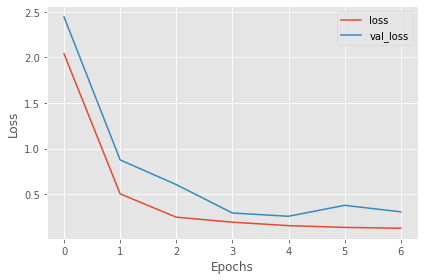

In [ ]:
plt.style.use("ggplot")
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()


##### Evaluate model

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(transfer_learning_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 90%


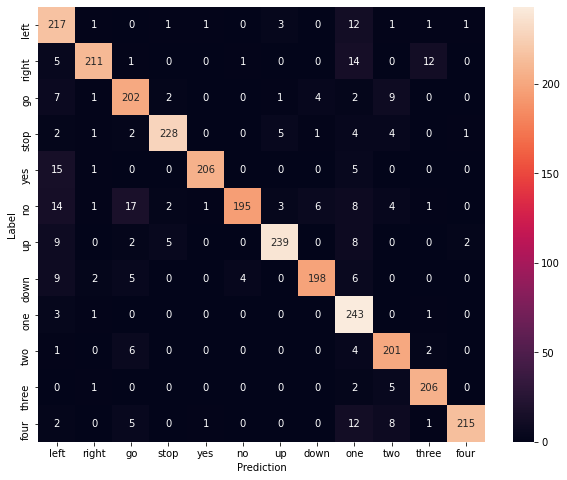

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


##### Save model

In [ ]:
path = '/content/drive/MyDrive/my_project/models/simple_resnet'

os.mkdir(path)
transfer_learning_model.save(path) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis_George_Giannios/models/simple_resnet/assets


##### Continue Learning

In [ ]:
path = '/content/drive/MyDrive/my_project/models/resnet_3ep'
new_model = tf.keras.models.load_model(path)

In [ ]:
# Continue learning process:
EPOCHS = 5
history = new_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/5
356/356 [==============================] - 3528s 10s/step - loss: 0.2243 - accuracy: 0.9279 - val_loss: 7.5879 - val_accuracy: 0.6103
Epoch 2/5
356/356 [==============================] - 122s 341ms/step - loss: 0.1589 - accuracy: 0.9488 - val_loss: 0.2904 - val_accuracy: 0.9125
Epoch 3/5
356/356 [==============================] - 122s 344ms/step - loss: 0.1225 - accuracy: 0.9594 - val_loss: 0.5207 - val_accuracy: 0.8742
Epoch 4/5
356/356 [==============================] - 123s 345ms/step - loss: 0.1219 - accuracy: 0.9598 - val_loss: 0.3097 - val_accuracy: 0.9164
Epoch 00004: early stopping


In [ ]:
plt.style.use("ggplot")
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(new_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 92%


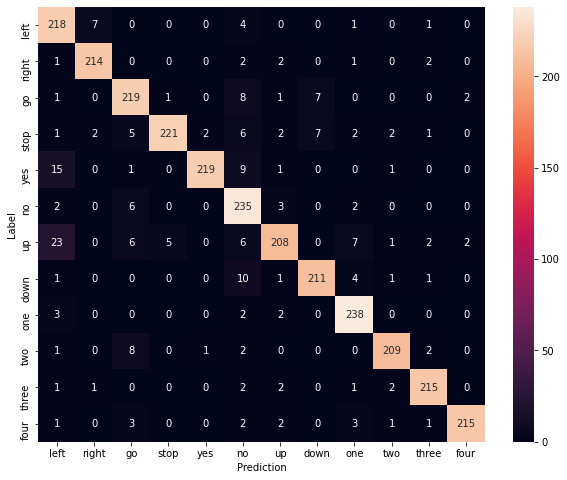

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
path = '/content/drive/MyDrive/my_project/models/resnet_8ep'

os.mkdir(path)
new_model.save(path) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis_George_Giannios/models/resnet_8ep/assets


#### SPECTROGRAM

In [ ]:
print(FEAT)

spectrogram


##### Define model

In [ ]:
def init_RESNET_model(summary):
  
  resnet_model=tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False,weights = None)
  
  RESNET_MODEL=resnet_model.layers[0](resnet_model)

  # unfreeze conv layers
  RESNET_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(12,activation='softmax')
  model = tf.keras.Sequential([RESNET_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model



In [ ]:
transfer_learning_model = init_RESNET_model(True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 5, 2048)        23581440  
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 5, 2048)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 12)                24588     
Total params: 23,606,028
Trainable params: 23,552,908
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# from_logits=False
transfer_learning_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [ ]:
# | Epochs | Time (min) | Val Acc (%) |
# |    10  |     13     |    41       |
EPOCHS = 10
history = transfer_learning_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
356/356 [==============================] - 103s 276ms/step - loss: 2.5176 - accuracy: 0.1773 - val_loss: 4.2401 - val_accuracy: 0.0787
Epoch 2/10
356/356 [==============================] - 98s 274ms/step - loss: 0.8439 - accuracy: 0.7192 - val_loss: 2.3993 - val_accuracy: 0.1655
Epoch 3/10
356/356 [==============================] - 97s 274ms/step - loss: 0.3984 - accuracy: 0.8700 - val_loss: 2.2894 - val_accuracy: 0.2467
Epoch 4/10
356/356 [==============================] - 98s 275ms/step - loss: 0.2709 - accuracy: 0.9121 - val_loss: 2.1221 - val_accuracy: 0.2888
Epoch 5/10
356/356 [==============================] - 97s 274ms/step - loss: 0.2298 - accuracy: 0.9223 - val_loss: 2.2064 - val_accuracy: 0.3377
Epoch 6/10
356/356 [==============================] - 97s 274ms/step - loss: 0.1886 - accuracy: 0.9384 - val_loss: 2.0076 - val_accuracy: 0.4051
Epoch 7/10
356/356 [==============================] - 97s 274ms/step - loss: 0.1553 - accuracy: 0.9466 - val_loss: 2.1655 - val_a

In [ ]:
plt.style.use("ggplot")
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()

##### Evaluate model

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(transfer_learning_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 53%


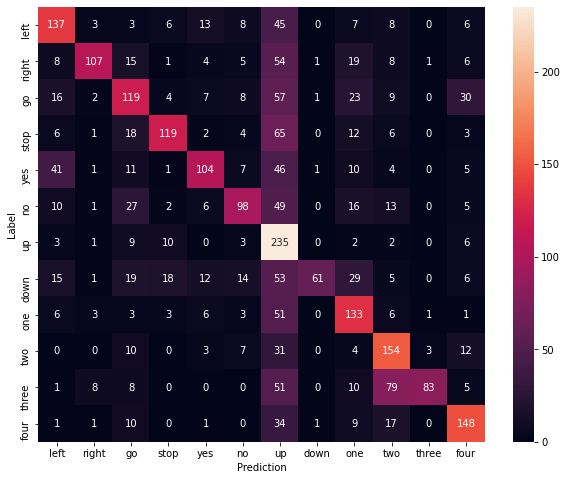

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


##### Save model

In [ ]:
path = '/content/drive/MyDrive/my_project/models/simple_resnet'

os.mkdir(path)
transfer_learning_model.save(path) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis_George_Giannios/models/simple_resnet/assets


##### Continue Learning

In [ ]:
path = '/content/drive/MyDrive/my_project/models/resnet_3ep'
new_model = tf.keras.models.load_model(path)

In [ ]:
# Continue learning process:
EPOCHS = 5
history = new_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/5
356/356 [==============================] - 3528s 10s/step - loss: 0.2243 - accuracy: 0.9279 - val_loss: 7.5879 - val_accuracy: 0.6103
Epoch 2/5
356/356 [==============================] - 122s 341ms/step - loss: 0.1589 - accuracy: 0.9488 - val_loss: 0.2904 - val_accuracy: 0.9125
Epoch 3/5
356/356 [==============================] - 122s 344ms/step - loss: 0.1225 - accuracy: 0.9594 - val_loss: 0.5207 - val_accuracy: 0.8742
Epoch 4/5
356/356 [==============================] - 123s 345ms/step - loss: 0.1219 - accuracy: 0.9598 - val_loss: 0.3097 - val_accuracy: 0.9164
Epoch 00004: early stopping


In [ ]:
plt.style.use("ggplot")
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(new_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 92%


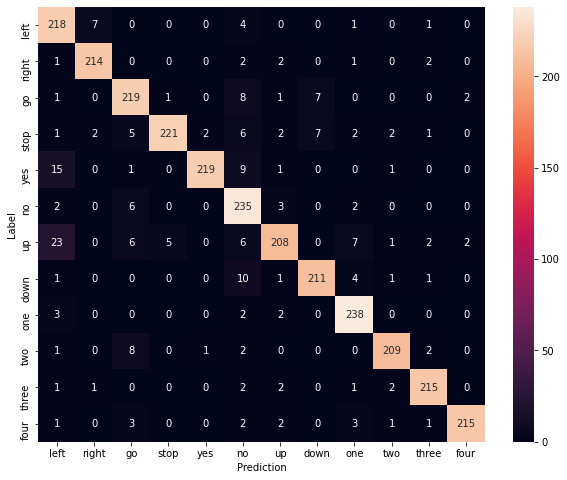

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
path = '/content/drive/MyDrive/my_project/models/resnet_8ep'

os.mkdir(path)
new_model.save(path) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis_George_Giannios/models/resnet_8ep/assets


#### DELTA - MFCC

In [ ]:
print(FEAT)

delta_mfcc


##### Define model

In [ ]:
def init_RESNET_model(summary):

  input_s = layers.Input((124,13,1))
  
  resnet_model=tf.keras.applications.EfficientNetB0(input_tensor = input_s,input_shape=(48,48,1), include_top=False,weights = None)
    
  RESNET_MODEL=resnet_model.layers[0](resnet_model)

  # unfreeze conv layers
  RESNET_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(12,activation='softmax')
  model = tf.keras.Sequential([RESNET_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model



In [ ]:
transfer_learning_model = init_RESNET_model(True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 4, 1, 1280)        4048991   
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 1, 1280)        0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 12)                15372     
Total params: 4,064,363
Trainable params: 4,022,344
Non-trainable params: 42,019
_________________________________________________________________


In [ ]:
# from_logits=True SOOOS
transfer_learning_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
# | Epochs | Time (min) | Val Acc (%) |
# |    10  |     ??     |    ??       | True 

EPOCHS = 30
history = transfer_learning_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=callbacks_list,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


356/356 [==============================] - 30s 60ms/step - loss: 2.4938 - accuracy: 0.1496 - val_loss: 2.5665 - val_accuracy: 0.0791

Epoch 00001: val_accuracy improved from -inf to 0.07906, saving model to weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
356/356 [==============================] - 19s 55ms/step - loss: 1.6498 - accuracy: 0.4260 - val_loss: 1.0372 - val_accuracy: 0.6469

Epoch 00002: val_accuracy improved from 0.07906 to 0.64687, saving model to weights.best.hdf5
Epoch 3/30
356/356 [==============================] - 19s 54ms/step - loss: 0.7337 - accuracy: 0.7638 - val_loss: 0.6686 - val_accuracy: 0.7930

Epoch 00003: val_accuracy improved from 0.64687 to 0.79304, saving model to weights.best.hdf5
Epoch 4/30
356/356 [==============================] - 20s 55ms/step - loss: 0.3988 - accuracy: 0.8700 - val_loss: 0.4201 - val_accuracy: 0.8696

Epoch 00004: val_accuracy improved from 0.79304 to 0.86964, saving model to weights.best.hdf5
Epoch 5/30
356/356 [==============================] - 20s 55ms/step - loss: 0.2685 - accuracy: 0.9131 - val_loss: 0.6398 - val_accuracy: 0.8299

Epoch 00005: val_accuracy did not improve from 0.86964
Epoch 6/30
356/356 [==============================] - 20s 55ms/step - loss: 0.2017 

No handles with labels found to put in legend.


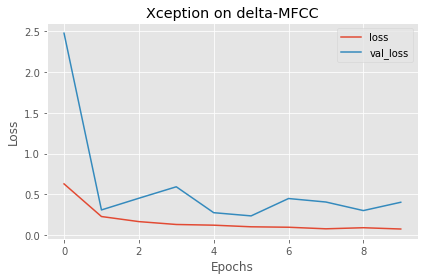

In [ ]:
plt.style.use("ggplot")
metrics = history.history

fig1 = plt.gcf()
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.title("Xception on delta-MFCC")
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()


fig1.savefig('Xception.png')

##### Evaluate model

In [ ]:
path = "weights.best.hdf5"

In [ ]:
transfer_learning_model.load_weights(path)

transfer_learning_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(transfer_learning_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.1%}')

Test set accuracy: 93.6%


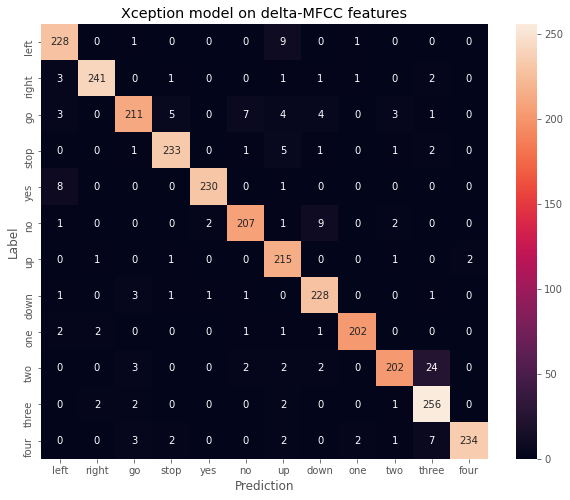

<Figure size 432x288 with 0 Axes>

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 

plt.figure(figsize=(10, 8))
plt.title("Xception model on delta-MFCC features")
fig2 = plt.gcf()
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
plt.draw()

fig2.savefig('xception.png')


##### Save model

In [ ]:
path = '/content/drive/MyDrive/my_project/models/simple_resnet'

os.mkdir(path)
transfer_learning_model.save(path) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis_George_Giannios/models/simple_resnet/assets


##### Continue Learning

In [ ]:
path = '/content/drive/MyDrive/my_project/models/resnet_3ep'
new_model = tf.keras.models.load_model(path)

In [ ]:
# Continue learning process:
EPOCHS = 5
history = new_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/5
356/356 [==============================] - 3528s 10s/step - loss: 0.2243 - accuracy: 0.9279 - val_loss: 7.5879 - val_accuracy: 0.6103
Epoch 2/5
356/356 [==============================] - 122s 341ms/step - loss: 0.1589 - accuracy: 0.9488 - val_loss: 0.2904 - val_accuracy: 0.9125
Epoch 3/5
356/356 [==============================] - 122s 344ms/step - loss: 0.1225 - accuracy: 0.9594 - val_loss: 0.5207 - val_accuracy: 0.8742
Epoch 4/5
356/356 [==============================] - 123s 345ms/step - loss: 0.1219 - accuracy: 0.9598 - val_loss: 0.3097 - val_accuracy: 0.9164
Epoch 00004: early stopping


In [ ]:
plt.style.use("ggplot")
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(new_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 92%


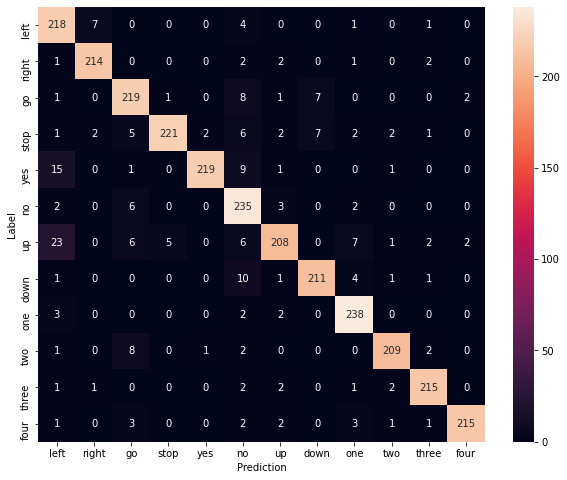

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
path = '/content/drive/MyDrive/my_project/models/resnet_8ep'

os.mkdir(path)
new_model.save(path) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis_George_Giannios/models/resnet_8ep/assets
